In [103]:
from fenics import *
import matplotlib.pyplot as plt
from mshr import *

# Tercer Parcial Modelización y Simulación II
## Javeriana Cali
## Matemáticas Aplicadas
### 2023-1 

**Fecha máxima de entrega**: 26 de mayo de 2023 11:59 pm


1. Usando el método de las caracteristicas resuelva la ecuación 

$$u_t-x^2u_x=0\, \, x\in R \text{ y } t>0$$
$$u(x,0)=x+1,\ \ \ x\in R$$ 
Dibuje la solución en el espacio $(x,t)$



2. Sea la siguiente ecuación del calor en 2D



$$u_{t} = \nabla^2u+f(x,y)=(u_{xx} + u_{yy})+f(x,y,t),$$
con condición
$$u(x,y,0) = \sin(2\pi x+2\pi y),$$
$$u(0,y,t) =sin(2\pi y)+1−\cos(2\pi t)\,\,0\leq y\leq 1,t\geq 0$$
$$u(1,y,t)=sin(\pi(2y+2))+1−\cos(2\pi t)\,\,0\leq y\leq 1,t\geq 0$$
$$u(x,0,t) =sin(2\pi y)+1−\cos(2\pi t)\,\,0\leq x\leq 1,t\geq 0$$
$$u(x,1,t)= sin(\pi(2y+2))+1−\cos(2\pi t)\,\,0\leq x\leq 1,t\geq 0$$
$\Omega=[0,1]\times[0,1]$.
y
$$f(x,y,t)=\displaystyle 2 \pi \sin{\left(2 \pi t \right)} + 8 \pi^{2} \sin{\left(\pi \left(2 x + 2 y\right) \right)},$$

El método $\theta$ para resolver la ecuación del calor es

$$u_t-\nabla^2 u=f\,\, en\, \Omega\times(0,T)$$

$$u=u_0 \,\, en\, \partial\Omega\times{\{0\}}$$

$$\frac{1}{\Delta t}\Big(u^{n+1}-u^n\Big)+\theta\Delta u^{n+1}-(1-\theta)\Delta u^n=\theta f(t_{n+1})+(1-\theta)f(t_{n})$$

Haga un análisis de convergencia numérica, para $\theta=0,1/2,2/3,1$, para ello encuentre el error $||\cdot||_2$ de diferentes mallas y en el mismo tiempo final $T=1$.
Luego encuentre el orden de convergencia numérica. Para ello recuerde que $$E=||u-u_h||_2\leq Ch^p$$ donde $p$ es el orden de convergencia numérica.
Note que la solución analítica del problema es  

$$\sin(2\pi x+2\pi y)−\cos(2\pi t)+1$$

R/ Primero debemos encontrar la formula variacional del problema:

$$ u_t - \Delta u = f \\
\frac{u^{n+1} - u^n}{dt} - \theta \Delta u^{n+1} - (1- \theta)\Delta u^n = \theta f(t_{n+1})+(1-\theta)f(t_{n})\\
u^{n+1} - u^n - dt \theta \Delta u^{n+1} - dt (1-\theta) \Delta u^n = dt \theta f(t_{n+1}) + dt(1-\theta)f(t_{n})\\
\int_{\Omega} v u^{n+1} - dt \theta v\Delta u^{n+1} \, dx = \int_{\Omega} v u^n + dt(1-\theta) \Delta u^n v \, dx + dt \int_{\Omega} (\theta f(t_{n+1})+(1-\theta)f(t_{n}))v \, dx 
$$
Aplicando Teorema de Green en los laplacianos, la integral de superficie es 0 pues la funcion test se anula en la frontera, por la tanto la formula variacional queda:
$$ \int_{\Omega} u^{n+1}v + dt \theta (\nabla u^{n+1} \cdot \nabla v) \, dx = \int_{\Omega} (u^n + dt \theta f(t_{n+1}) + dt(1-\theta)f(t_n))v - dt(1-\theta)(\nabla u^n \cdot \nabla v) \, dx $$


In [104]:
# Define mesh and function space
domain = Rectangle(Point(0, 0), Point(1, 1))
mesh = generate_mesh(domain, 100)

#Discretization
T = 1.0 # final time
num_steps = 100 # number of time steps
dt = T / num_steps # time step size

V = FunctionSpace(mesh, 'Lagrange', 1)

# Define functions for boundary conditions
t = 0
u_D_top = Expression('sin(2*pi*(x[0]+1)) + 1 - cos(2*pi*t)',degree=2, t=t) #y=1
u_D_bottom = Expression('sin(2*pi*x[0]) + 1 - cos(2*pi*t)',degree=2, t=t) #y=0
u_D_left = Expression('sin(2*pi*x[1]) + 1 - cos(2*pi*t)',degree=2, t=t) #x=0
u_D_right = Expression('sin(2*pi*(x[1]+1)) + 1 - cos(2*pi*t)',degree=2, t=t) # x=1

# Define the boundary condition
def boundary_top(x, on_boundary):
    return on_boundary and near(x[1], 1.0)
def boundary_bottom(x, on_boundary):
    return on_boundary and near(x[1], 0.0)
def boundary_left(x, on_boundary):
    return on_boundary and near(x[0], 0.0)
def boundary_right(x, on_boundary):
    return on_boundary and near(x[0], 1.0)

bc_top = DirichletBC(V, u_D_top, boundary_top)
bc_bottom = DirichletBC(V, u_D_bottom, boundary_bottom)
bc_left = DirichletBC(V, u_D_left, boundary_left)
bc_right = DirichletBC(V, u_D_right, boundary_right)

bc = [bc_top, bc_bottom, bc_left, bc_right]

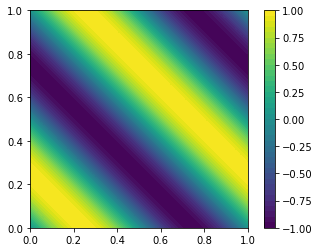

In [105]:
# The initial condition t=0. u(x,y,0) = sin(2*pi*(x + y))
initial_condition = Expression("sin(2*pi*(x[0] + x[1]))",degree=2)
u_k_old = interpolate(initial_condition,V)
p = plot(u_k_old)
plt.colorbar(p)

In [106]:
# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)
theta = 1
# f(x,y,t)= 2*pi*sin(2*pi*t) + 8*pi^2 * sin(2*pi*(x + y))
exp = Expression('2*pi*sin(2*pi*t) + 8*pi*pi * sin(2*pi*(x[0] + x[1]))',degree=2, t=t)
f_old = exp
f = exp
a = (u*v + dt*theta*inner(nabla_grad(u), nabla_grad(v)))*dx
L = ((u_k_old + dt*theta*f + dt*(1-theta)*f_old)*v - dt*(1-theta)*inner(nabla_grad(u_k_old), nabla_grad(v)))*dx

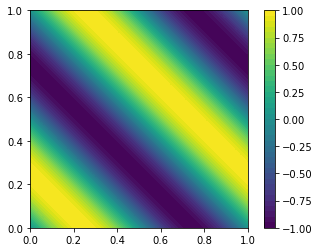

In [107]:
u_exact = Expression('sin(2*pi*(x[0] + x[1])) - cos(2*pi*t) + 1',degree=2, t=t)
u_e = interpolate(u_exact, V)
p = plot(u_e)
plt.colorbar(p)

In [108]:
# Error at t=0
error_L2 = errornorm(interpolate(initial_condition,V), interpolate(u_exact, V))
print(error_L2)

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
5.177645470662003e-17


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

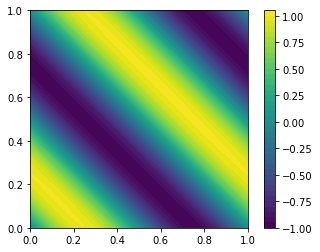

In [109]:
fid = File("parcial3/heat/solution.pvd")
# Time-stepping
u = Function(V)
t = 0
while t <= T:
    # Update time
    t += dt
    # Update time for boundary conditions
    u_D_top.t = t
    u_D_bottom.t = t
    u_D_left.t = t
    u_D_right.t = t
    # Update time for the fs
    f_old.t = t - dt
    f.t = t
    # Update time for exact solution
    u_e.t = t 
    # Solve variational problem at current time step
    solve(a == L, u, bc)
    # Plot solution
    p = plot(u)
    # Calculate error
    #e = errornorm(u, u_e, 'L2') #error at current time
    #errors.append(e)
    # Update previous solution
    u_k_old.assign(u)
    fid << u, t
plt.colorbar(p)

$$ E = \sqrt{\int_{\Omega} (u - u_h)^ 2 \, dx} $$

In [110]:
# Error at final time
e = u - u_e
assemble(e**2*dx(mesh))

5.3183088628190536e-05

# Ecuación de onda

Sea la ecuación de onda en 2D

$$u_{tt} = \nabla^2u + f(x,y,t),$$
con
$$f(x,y,t)=−4\pi^2x^2\cos(2\pi xy)-4\pi^2y^2 \cos(2\pi x y)-4\pi^2\sin(2\pi t)$$

$$u(x,y,0) = \displaystyle 1 - \cos{\left(2 \pi x y \right)},$$
$$u_t(x,y,0) =2\pi,$$

y condiciones de frontera
$u|_{\partial \Omega}=\sin(2\pi t)+1-\cos(2\pi xy)$ con $\Omega=[0,1]\times[0,1]$.

El problema numérico es
$$u_{tt}-\Delta u=f\,\, in\,\Omega\times(0,T]$$

$$u=0\,\, on\,\partial\Omega\times(0,T]$$
$$u(\cdot,t)=u_0\,\, in\,\Omega$$
$$u_t(\cdot,t)=g\,\, in\,\Omega$$

$$\frac{1}{(\Delta t)^2} \Big(u^{n+1}-2u^n+u^{n-1}\Big)-\frac{1}{2}\Delta(u^{n+1}+u^{n-1})= f(t^n)$$

with $u¹=u^0+u_t\Delta t$.

La solución analítica del problema es 

$$u(x,y,t)=\sin(2\pi t)+1-\cos(2\pi xy)$$

Haga un análisis de convergencia numérica, para ello encuentre el error $||\cdot||_2$ de diferentes mallas y en el mismo tiempo final $T=1$. Luego encuentre el orden de convergencia numérica. Para ello recuerde que $$E=||u-u_h||_2\leq Ch^p$$ donde $p$ es el orden de convergencia numérica.


Primero debemos calcular la formula variacional:
$$ 
u_{tt} = \Delta u + f\\
\frac{u^{k+2} - 2u^{k+1} + u^k}{dt^2} = \frac{1}{2} \Delta (u^{k+2} + u^k) + f(t_n)\\
\int_{\Omega} vu^{k+2} - 2vu^{k+1} + vu^k \, dx = dt^2 \int_{\Omega} \frac{1}{2} \Delta(u^{k+2} + u^k)v + vf(t_n) \, dx
$$
Aplicando Teorema de Green en el laplaciano obtenemos que:
$$
\int_{\Omega} \Delta(u^{k+2} + u^k)v \, dx = - \int_{\Omega} \nabla(u^{k+2} + u^k)\cdot \nabla v \, dx\\
\int_{\Omega} \Delta(u^{k+2} + u^k)v \, dx = - \int_{\Omega} \nabla u^{k+2} \cdot \nabla v + \nabla u^k \cdot \nabla v \, dx
$$
Entonces:
$$
\int_{\Omega} vu^{k+2} - 2vu^{k+1} + vu^k \, dx = dt^2 \int_{\Omega} vf(t_n) - \frac{1}{2}(\nabla u^{k+2} \cdot \nabla v + \nabla u^k \cdot \nabla v) \, dx\\
\int_{\Omega} vu^{k+2} + \frac{dt^2}{2}(\nabla u^{k+2} \cdot \nabla v) \, dx = \int_{\Omega} (dt^2 f(t_n) + 2u^{k+1} - u^k)v - \frac{dt^2}{2}(\nabla u^k \cdot \nabla v) \, dx
$$

In [134]:
# Define mesh and function space
domain = Rectangle(Point(0, 0), Point(1, 1))
mesh = generate_mesh(domain, 100)

#Discretization
T = 1.0 # final time
num_steps = 100 # number of time steps
dt = T / num_steps # time step size

V = FunctionSpace(mesh, 'Lagrange', 1)

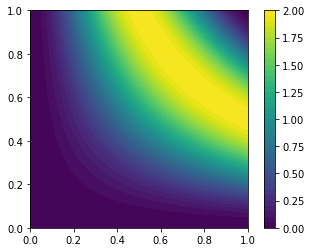

In [135]:
fid = File("parcial3/wave/solution.pvd")

# Define the boundary condition
t = 0
u_D = Expression("sin(2*pi*t) + 1 - cos(2*pi*x[0]*x[1])",degree=2, t=t)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# The initial condition t=0. u(x,y,0) = 1 - cos(2*pi*x*y)
initial_condition = Expression("1 - cos(2*pi*x[0]*x[1])",degree=2)
u_k = interpolate(initial_condition,V)
p = plot(u_k)
plt.colorbar(p)

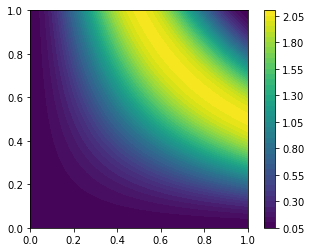

In [136]:
# u^1 = u^0 + g(x,y) * dt
u_k1 = Expression("1 - cos(2*pi*x[0]*x[1]) + 2*pi*dt",degree=2, dt=dt)
u_k1 = interpolate(u_k1,V)
p = plot(u_k1)
plt.colorbar(p)

In [137]:
# Define varational problem
u_k2 = TrialFunction(V)
v = TestFunction(V)
f = Expression("-4*pi*pi*cos(2*pi*x[0]*x[1])*(x[0]*x[0] + x[1]*x[1]) - 4*pi*pi*sin(2*pi*t)",degree=2, t=t)

a = (v*u_k2 + (dt*dt/2)*inner(nabla_grad(u_k2),nabla_grad(v)))*dx
L = ((dt*dt*f + 2*u_k1 - u_k)*v - (dt*dt/2)*inner(nabla_grad(u_k),nabla_grad(v)))*dx

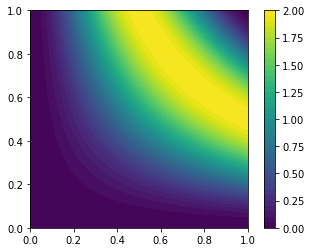

In [138]:
u_exact = Expression('sin(2*pi*t) + 1 - cos(2*pi*x[0]*x[1])',degree=2, t=t)
u_e = interpolate(u_exact, V)
p = plot(u_e)
plt.colorbar(p)

In [139]:
# Error at t=0
error_L2 = errornorm(interpolate(initial_condition,V), interpolate(u_exact, V))
print(error_L2)

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.0


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

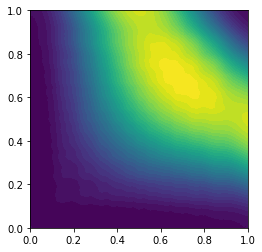

In [140]:
# Time-stepping
u = Function(V)
t = 0
while t <= T:
    # Update time
    t += dt
    f.t = t
    u_D.t = t
    u_e.t = t 
    # Solve variational problem at current time step
    solve(a == L, u, bc)
    # Plot solution
    plot(u)    
    # Update previous solution
    u_k.assign(u_k1)
    u_k1.assign(u)
    # Save solution through time to visualize in paraview
    fid << u, t

In [141]:
# Error at final time
e = u - u_e
assemble(e**2*dx(mesh))

0.01590409534591551